In [2]:
import os
import re
import string
import random
from glob import glob
from argparse import Namespace

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

2.10.0


In [24]:
import wandb
from wandb.keras import WandbMetricsLogger
from wandb.keras import WandbModelCheckpoint

In [3]:
def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

random_id = id_generator(size=8)
print('Experiment Id: ', random_id)


configs = Namespace(
    num_frames = 32,
    batch_size = 128,
    epochs = 60,
    resizing_interpolation = "nearest",
    learning_rate = 1e-3,
    num_steps = 1.0,
    experiment_id = random_id,
    num_jcd_features = 3321, # ((82*82)-82)/2
    num_classes = 250,
    filters = 256,
)


LIP = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]

RIGHT_EYE = [
    246, 161, 160, 159, 158, 157, 173,
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    247, 30, 29, 27, 28, 56, 190,
    130, 25, 110, 24, 23, 22, 26, 112, 243,
    113, 225, 224, 223, 222, 221, 189,
    226, 31, 228, 229, 230, 231, 232, 233, 244,
    143, 111, 117, 118, 119, 120, 121, 128, 245,
]

LEFT_EYE = [
    466, 387, 386, 385, 384, 398,
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    467, 260, 259, 257, 258, 286, 414,
    359, 255, 339, 254, 253, 252, 256, 341, 463,
    342, 445, 444, 443, 442, 441, 413,
    446, 261, 448, 449, 450, 451, 452, 453, 464,
    372, 340, 346, 347, 348, 349, 350, 357, 465,
]
    
LEFT_HAND = [
    468, 469, 470, 471, 472, 473, 474, 475,
    476, 477, 478, 479, 480, 481, 482, 483,
    484, 485, 486, 487, 488
]

RIGHT_HAND = [
    522, 523, 524, 525, 526, 527, 528, 529,
    530, 531, 532, 533, 534, 535, 536, 537,
    538, 539, 540, 541, 542
]

Experiment Id:  EFGV7A4J


In [26]:
data_path = "../data/tfrecords"


def natural_keys(text):
    ""
    def atoi(text):
        return int(text) if text.isdigit() else text
    
    return [atoi(c) for c in re.split(r'(\d+)', text)]

tfrecords = sorted(glob(f"{data_path}/*.tfrec"), key=natural_keys)
len(tfrecords)

24

In [27]:
MIN_C = np.array([-0.04930535, 0.81610775, -1.1901336])
MAX_C = np.array([1.449954, 1.0650164, -0.48345777])

In [28]:
MAX_C - MIN_C

array([1.49925935, 0.24890865, 0.70667583])

In [9]:
train_tfrecords, valid_tfrecords = tfrecords[:19], tfrecords[19:]

def parse_sequence(serialized_sequence):
    return tf.io.parse_tensor(
        serialized_sequence,
        out_type=tf.float32,
    )


def parse_tfrecord_fn(example):
    feature_description = {
        "n_frames": tf.io.FixedLenFeature([], tf.float32),
        "frames": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    
    return tf.io.parse_single_example(example, feature_description)


@tf.function
def preprocess_frames(frames):
    """
    In this preprocessing function:
    - Fill NaN values to 0.
    - Use `tf.image.resize` to interpolate.
    """
    # change -z to z
#     frames = tf.math.multiply(frames, [1,1,-1])
    # Standardize
    frames = (frames - MIN_C) / (MAX_C - MIN_C)
    frames = 255 * frames
    
    # NaN to 0
    frames = tf.where(tf.math.is_nan(frames), 0.0, frames)

    # Resize
    frames = tf.image.resize(
        frames, (configs.num_frames, 543), method=configs.resizing_interpolation
    )
    
    return frames


def parse_data(example):
    # Parse Frames
    n_frames = example["n_frames"]
    frames = tf.reshape(parse_sequence(example["frames"]), shape=(n_frames, 543, 3))
#     frames = preprocess_frames(frames)
    
    # Parse Labels
    label = tf.one_hot(example["label"], depth=250)

    return frames, label


AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.TFRecordDataset(train_tfrecords)
valid_ds = tf.data.TFRecordDataset(valid_tfrecords)

trainloader = (
    train_ds
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .shuffle(1024)
    .map(parse_data, num_parallel_calls=AUTOTUNE)
    .batch(1)
    .prefetch(AUTOTUNE)
)

validloader = (
    valid_ds
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .map(parse_data, num_parallel_calls=AUTOTUNE)
    .batch(128)
    .prefetch(AUTOTUNE)
)

In [29]:
sample, _ = next(iter(trainloader))
sample = sample[0]

In [30]:
sample

<tf.Tensor: shape=(8, 543, 3), dtype=float32, numpy=
array([[[ 0.43045917,  0.48798028, -0.05091354],
        [ 0.41856372,  0.43558612, -0.07141284],
        [ 0.42197806,  0.4517281 , -0.0436361 ],
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       [[ 0.4267037 ,  0.48686847, -0.05025025],
        [ 0.41319862,  0.4300508 , -0.06878123],
        [ 0.41712552,  0.44643524, -0.04261369],
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       [[ 0.4260299 ,  0.47794083, -0.04975466],
        [ 0.41683212,  0.4273697 , -0.07033914],
        [ 0.42015132,  0.44274646, -0.04291803],
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       ...,

       

In [41]:
x = np.floor(255*((sample - MIN_C) / (MAX_C - MIN_C)))
x = np.array(tf.where(tf.math.is_nan(x), 0.0, x))
x = x/x.max()
x

array([[[ 0.04625928, -0.19246145,  0.23472302],
        [ 0.04511708, -0.22272986,  0.2301542 ],
        [ 0.04568818, -0.21359223,  0.23586522],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.04568818, -0.19303255,  0.23472302],
        [ 0.04454597, -0.22615649,  0.2307253 ],
        [ 0.04511708, -0.21644774,  0.23643632],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.04568818, -0.19817248,  0.23472302],
        [ 0.04511708, -0.2278698 ,  0.2307253 ],
        [ 0.04511708, -0.21873215,  0.23586522],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       ...,

       [[ 0.04568818, -0.2033124 ,  0.23415191],
        [ 0

In [43]:
x.max()

1.0

In [70]:
from tqdm import tqdm

min_c = [np.inf, np.inf, np.inf]
max_c = [np.inf, np.inf, np.inf]

for idx, (frames, _) in tqdm(enumerate(trainloader)):
    frames = tf.squeeze(frames, axis=0).numpy()
    for frame in frames:
        for i in range(len(frame)):
            min_c = min(list(frame[i]), min_c)
            max_c = max(list(frame[i]), max_c)

74797it [1:35:09, 13.10it/s]


In [73]:
# Get labels 2 id
import json

with open("../data/sign_to_prediction_index_map.json") as f:
    label2id = json.load(f)
    
id2label = {v:k for k,v in label2id.items()}
id2label

{0: 'TV',
 1: 'after',
 2: 'airplane',
 3: 'all',
 4: 'alligator',
 5: 'animal',
 6: 'another',
 7: 'any',
 8: 'apple',
 9: 'arm',
 10: 'aunt',
 11: 'awake',
 12: 'backyard',
 13: 'bad',
 14: 'balloon',
 15: 'bath',
 16: 'because',
 17: 'bed',
 18: 'bedroom',
 19: 'bee',
 20: 'before',
 21: 'beside',
 22: 'better',
 23: 'bird',
 24: 'black',
 25: 'blow',
 26: 'blue',
 27: 'boat',
 28: 'book',
 29: 'boy',
 30: 'brother',
 31: 'brown',
 32: 'bug',
 33: 'bye',
 34: 'callonphone',
 35: 'can',
 36: 'car',
 37: 'carrot',
 38: 'cat',
 39: 'cereal',
 40: 'chair',
 41: 'cheek',
 42: 'child',
 43: 'chin',
 44: 'chocolate',
 45: 'clean',
 46: 'close',
 47: 'closet',
 48: 'cloud',
 49: 'clown',
 50: 'cow',
 51: 'cowboy',
 52: 'cry',
 53: 'cut',
 54: 'cute',
 55: 'dad',
 56: 'dance',
 57: 'dirty',
 58: 'dog',
 59: 'doll',
 60: 'donkey',
 61: 'down',
 62: 'drawer',
 63: 'drink',
 64: 'drop',
 65: 'dry',
 66: 'dryer',
 67: 'duck',
 68: 'ear',
 69: 'elephant',
 70: 'empty',
 71: 'every',
 72: 'eye',
 

In [74]:
samples, labels = next(iter(trainloader))
samples

<tf.Tensor: shape=(1, 54, 543, 3), dtype=float32, numpy=
array([[[[ 0.47881383,  0.47504663, -0.04321275],
         [ 0.47857738,  0.43265402, -0.0605206 ],
         [ 0.47969326,  0.4454293 , -0.03614771],
         ...,
         [ 0.33654892,  0.6844093 , -0.10143371],
         [ 0.35334253,  0.7131288 , -0.08925071],
         [ 0.35125703,  0.73177767, -0.07491513]],

        [[ 0.48144597,  0.4739204 , -0.04246955],
         [ 0.4779333 ,  0.43379244, -0.06057076],
         [ 0.4792229 ,  0.44626126, -0.03587906],
         ...,
         [ 0.3284788 ,  0.6784022 , -0.09722248],
         [ 0.34323227,  0.7082164 , -0.08614843],
         [ 0.34229854,  0.7286104 , -0.07187299]],

        [[ 0.4826412 ,  0.4736914 , -0.04305909],
         [ 0.4804488 ,  0.43340963, -0.06074397],
         [ 0.4812621 ,  0.44583565, -0.03615693],
         ...,
         [ 0.33411184,  0.6762175 , -0.08901671],
         [ 0.3497692 ,  0.70375085, -0.07811157],
         [ 0.3472429 ,  0.7236788 , -0.06572422

In [75]:
labels = np.argmax(labels, axis=1)
labels

array([47])

In [40]:
# Psuedo code but working!

In [76]:
lip_inputs = tf.gather(samples, indices=LIP, axis=2)
left_hand_inputs = samples[:, :, 468:489, :]
right_hand_inputs = samples[:, :,522:,:]
samples = tf.keras.layers.Concatenate(axis=2)(
    [lip_inputs, right_hand_inputs, left_hand_inputs]
)

In [87]:
sample = samples[0]
sample

<tf.Tensor: shape=(54, 82, 3), dtype=float32, numpy=
array([[[ 0.43868756,  0.4916583 , -0.00947222],
        [ 0.4405604 ,  0.48726627, -0.01735631],
        [ 0.44538593,  0.48256332, -0.0256984 ],
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       [[ 0.43781945,  0.49161753, -0.0079173 ],
        [ 0.4405206 ,  0.48739445, -0.01587842],
        [ 0.4462313 ,  0.48263532, -0.02440712],
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       [[ 0.43889776,  0.4923789 , -0.00968695],
        [ 0.44165856,  0.48801172, -0.01757443],
        [ 0.44738707,  0.48305473, -0.02591663],
        ...,
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]],

       ...,

       

In [78]:
f1 = sample[0]
f1

<tf.Tensor: shape=(82, 3), dtype=float32, numpy=
array([[ 4.38687563e-01,  4.91658300e-01, -9.47221927e-03],
       [ 4.40560400e-01,  4.87266272e-01, -1.73563100e-02],
       [ 4.45385933e-01,  4.82563317e-01, -2.56983992e-02],
       [ 4.52780634e-01,  4.77479875e-01, -3.33428085e-02],
       [ 4.65283543e-01,  4.73183811e-01, -4.01901267e-02],
       [ 4.78813827e-01,  4.75046635e-01, -4.32127491e-02],
       [ 4.92441982e-01,  4.72218573e-01, -4.22814563e-02],
       [ 5.06920457e-01,  4.75913703e-01, -3.76189239e-02],
       [ 5.16562402e-01,  4.80604142e-01, -3.14839594e-02],
       [ 5.23644090e-01,  4.85357642e-01, -2.42551081e-02],
       [ 5.27829707e-01,  4.89970744e-01, -1.69580374e-02],
       [ 4.42585528e-01,  4.94380832e-01, -1.80413052e-02],
       [ 4.48128581e-01,  4.97254461e-01, -2.68949755e-02],
       [ 4.56807673e-01,  5.01146972e-01, -3.30545269e-02],
       [ 4.68086392e-01,  5.04212439e-01, -3.79352570e-02],
       [ 4.81542766e-01,  5.05028605e-01, -3.963169

In [79]:
x = f1[:,0]
y = f1[:,1]
z = f1[:,2]

In [80]:
x

<tf.Tensor: shape=(82,), dtype=float32, numpy=
array([0.43868756, 0.4405604 , 0.44538593, 0.45278063, 0.46528354,
       0.47881383, 0.49244198, 0.50692046, 0.5165624 , 0.5236441 ,
       0.5278297 , 0.44258553, 0.44812858, 0.45680767, 0.4680864 ,
       0.48154277, 0.49563855, 0.50820637, 0.51770645, 0.5237025 ,
       0.4425802 , 0.4482733 , 0.45335537, 0.46052295, 0.46961343,
       0.48040766, 0.49145597, 0.50183624, 0.5106645 , 0.5173775 ,
       0.44856578, 0.4539321 , 0.46102977, 0.4699921 , 0.48056477,
       0.49151137, 0.50182426, 0.51051956, 0.51721287, 0.5237974 ,
       0.31918925, 0.39600044, 0.46284783, 0.50352925, 0.5262668 ,
       0.4320271 , 0.45616782, 0.49086994, 0.52140206, 0.3810465 ,
       0.4412547 , 0.4597827 , 0.45851848, 0.3322369 , 0.38877878,
       0.4012656 , 0.39460775, 0.28644425, 0.33654892, 0.35334253,
       0.35125703,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              n

In [18]:
run = wandb.init(
    project="kaggle-asl",
    job_type="eda",
)

for idx, (sample, label) in enumerate(zip(samples, labels)):
#     sample = (sample.numpy() - np.array(min_c))/(np.array(max_c) - np.array(min_c))
    wandb.log({f"images": wandb.Image(sample, caption=f"{id2label[label]}")})
    
    if idx==32:
        break

wandb.finish()

wandb: Currently logged in as: ayush-thakur. Use `wandb login --relogin` to force relogin


In [108]:
sample.numpy().min()

-0.16729814

In [92]:
sample1 = (sample.numpy() - np.array(min_c))/(np.array(max_c) - np.array(min_c))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


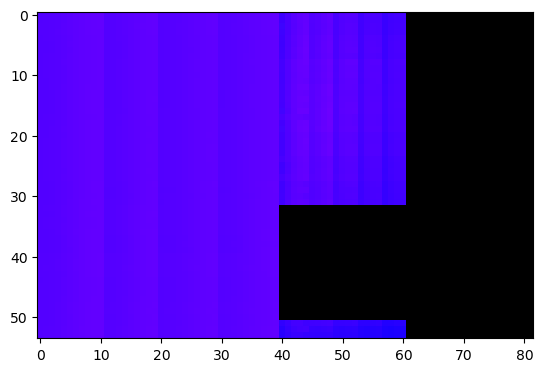

In [86]:
plt.imshow(sample)